In [57]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import warnings 
warnings.filterwarnings('ignore')

### **ADP 24**

In [2]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem1.csv')
df.head()

,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
0,F,18.0,A,4,4,mother,2,2.0,0,4,3.0,6
1,F,17.0,T,1,1,father,2,1.0,0,5,3.0,4
2,F,15.0,T,1,1,mother,2,1.0,3,4,3.0,10
3,F,15.0,T,2,4,mother,3,1.0,0,3,2.0,2
4,F,NaN,T,3,3,father,2,1.0,0,4,3.0,4


In [35]:
df['age'].value_counts()

age
16.0    102
17.0     97
18.0     82
15.0     82
19.0     24
20.0      3
22.0      1
21.0      1
Name: count, dtype: int64

##### 1.1 EDA 및 시각화

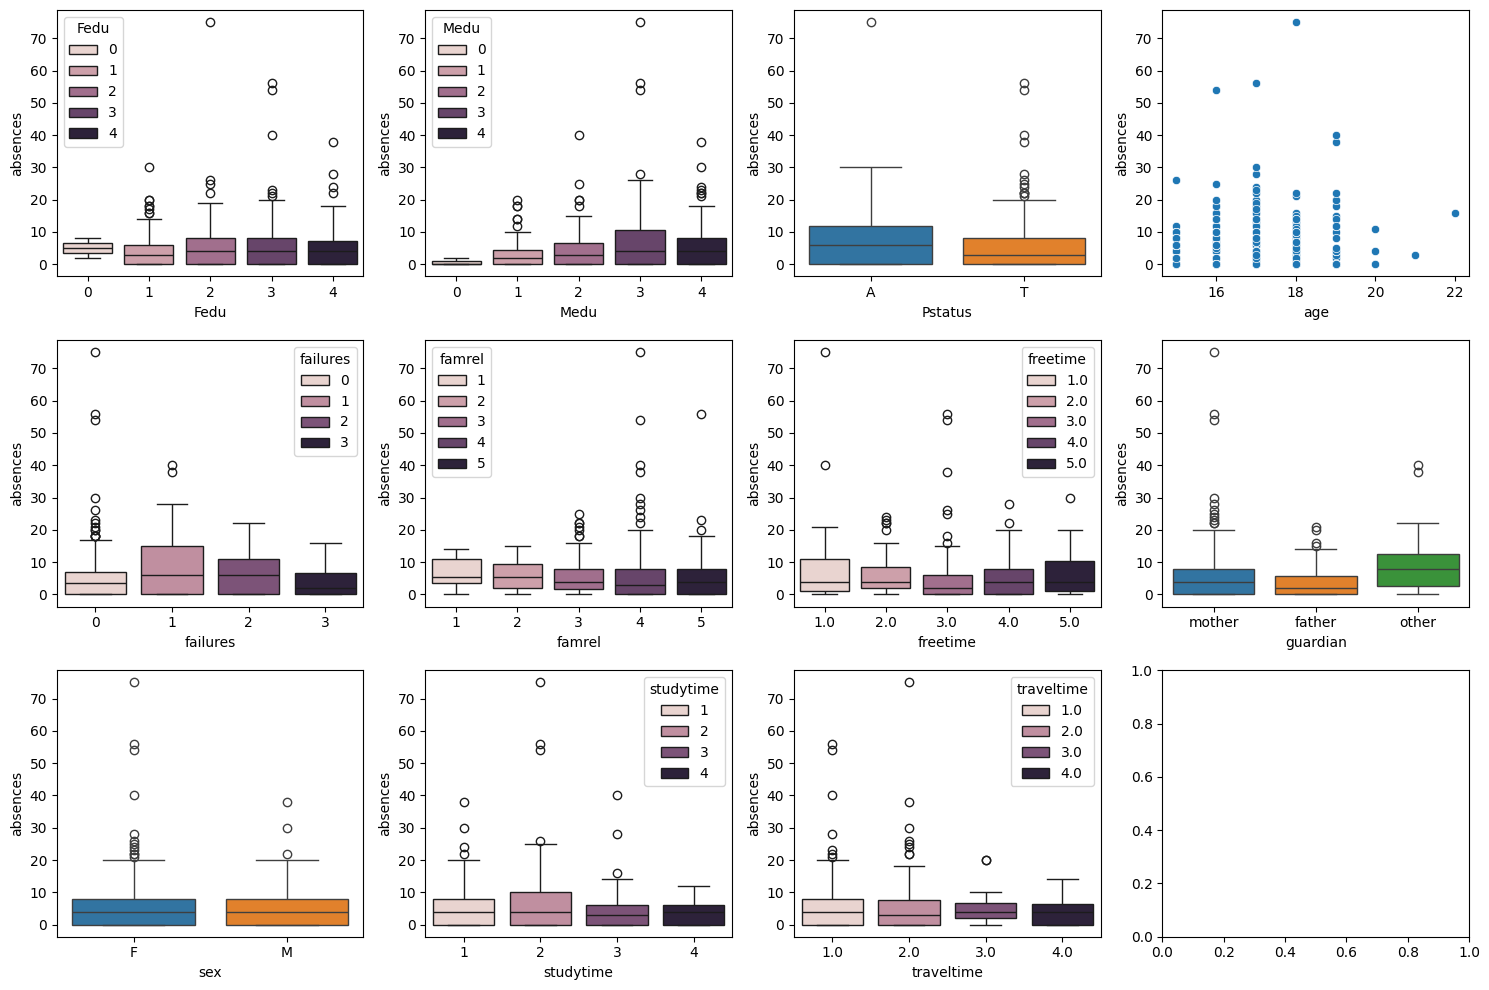

,Columns,P_vale,Decision
0,Fedu,0.828406,유의하지않다
1,Medu,0.020004,유의하다
2,Pstatus,0.007240,유의하다
3,age,NaN,유의하지않다
4,failures,0.004044,유의하다
5,famrel,0.840974,유의하지않다
6,freetime,0.038091,유의하다
7,guardian,0.003073,유의하다
8,sex,0.184141,유의하지않다
9,studytime,0.331916,유의하지않다


In [41]:
from scipy.stats import pearsonr
fig, axes = plt.subplots(3,4, figsize = (15, 10))

res = []
for axes, col in zip(axes.flatten(), df.columns.difference(['absences'])) :
    if df[col].nunique() == 2 :
        group = df.groupby(col)['absences'].apply(list)
        stat , p_val = stats.ttest_ind(group[0], group[1]) 

        target = df[[col, 'absences']]
        sns.boxplot(data = target, x = col, y = 'absences', hue = col, ax = axes) 
        

    elif 2 < df[col].nunique() < 6 :
        g = [group['absences'] for name, group in df.groupby(col)]
        stat, p_val = stats.f_oneway(*g) 

        target = df[[col, 'absences']]
        sns.boxplot(data = target, x = col, y = 'absences', hue = col, ax = axes)

    else : 
        stat, p_val = pearsonr(df[col], df['absences'])
        sns.scatterplot(data=df, x=col, y='absences', ax=axes) 

    res.append({
        'Columns' : col, 
        'P_vale' : p_val, 
        'Decision' : '유의하다' if p_val < 0.05 else '유의하지않다' 
    })

plt.legend().remove()
plt.tight_layout()
plt.show()

display(pd.DataFrame(res))

 ##### 1.2 결측치 처리 및 변화 시각화, 추가 전처리가 필요하다면 이유와 기대효과를 설명

In [43]:
df.isna().sum().to_frame().T

,sex,age,Pstatus,Fedu,Medu,guardian,studytime,traveltime,failures,famrel,freetime,absences
0,0,3,0,0,0,0,0,3,0,0,5,0


In [44]:
df1 = df.copy()
df1['age'] = df1['age'].fillna(df1['age'].mean())
df1['traveltime'] = df1['traveltime'].fillna(df1['traveltime'].mode()[0])
df1['freetime'] = df1['freetime'].fillna(df1['freetime'].mode()[0])

##### 1.3 결석일수 예측모델을 2개 제시하고 선택한 근거 설명
##### 1.4 선정한 모델 2가지 생성 및 모델의 평가 기준을 선정하고 선정 이유 설명

In [62]:
# 전처리 
cleand_df = pd.DataFrame()

for col in df1.columns : 
    if col == 'absences' :
        cleand_df[col] = df1[col]
    elif df1[col].dtypes == 'object' : 
        dummies = pd.get_dummies(df1[col], prefix = col, dtype = int)
        for d_col in dummies.columns : 
            cleand_df[d_col] = dummies[d_col]
    else : 
        cleand_df[col] = df1[col]

cleand_df.head(4)

,sex_F,sex_M,age,Pstatus_A,Pstatus_T,Fedu,Medu,guardian_father,guardian_mother,guardian_other,studytime,traveltime,failures,famrel,freetime,absences
0,1,0,18.0,1,0,4,4,0,1,0,2,2.0,0,4,3.0,6
1,1,0,17.0,0,1,1,1,1,0,0,2,1.0,0,5,3.0,4
2,1,0,15.0,0,1,1,1,0,1,0,2,1.0,3,4,3.0,10
3,1,0,15.0,0,1,2,4,0,1,0,3,1.0,0,3,2.0,2


In [63]:
X = cleand_df.drop(columns = 'absences', axis = 1)
y = cleand_df['absences']

In [65]:

def eval_model(name, model) : 
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
    model.fit(x_train, y_train)
    pred = model.predict(x_test)

    rmse = np.sqrt(mean_squared_error(y_test, pred))
    r2 = r2_score(y_test, pred)

    return name, rmse, r2 

res = []
model_lst = []
for name, model in [['RF', RandomForestRegressor()] ,['LR',LinearRegression()]] : 
    name, rmse , r2 = eval_model(name, model)
    res.append([name, rmse, r2])
    model_lst.append([name, model])

result = pd.DataFrame(res, columns = ['Model Name','RMSE','R2'])
print(result)

  Model Name      RMSE        R2
0         RF  6.967479 -0.325064
1         LR  6.181273 -0.042897


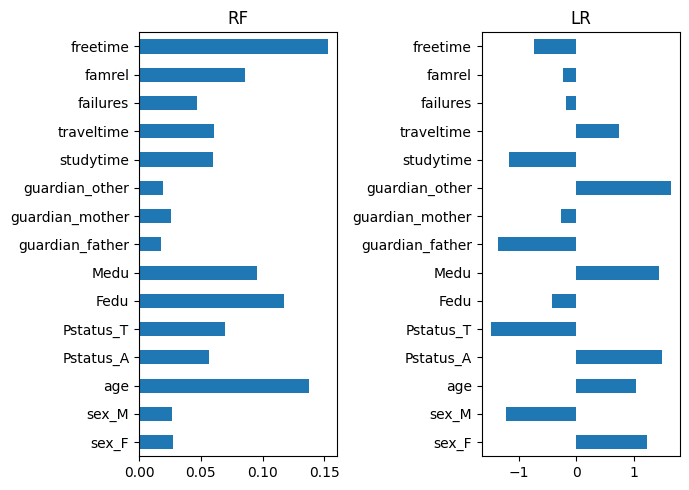

In [77]:
# Feature Importance
fig, axes = plt.subplots(1,2, figsize = (7, 5))
for idx, (name, model) in enumerate(model_lst) : 
    if name == 'RF' : 
        imp = model.feature_importances_
        feature = model.feature_names_in_
        imp_df = pd.Series(imp, index = feature)
    else : 
        imp = model.coef_
        feature = X.columns 
        imp_df = pd.Series(imp, index = feature)

    imp_df.plot(kind = 'barh', ax = axes[idx])
    axes[idx].set_title(name)
plt.tight_layout()
plt.show()

##### 2.1 광고비 변수를 가변수 처리후 다중회귀를 수행하여 회귀계수가 유의한지 검정

In [78]:
df= pd.read_csv('https://raw.githubusercontent.com/Datamanim/datarepo/main/adp/24/problem2.csv',encoding='cp949')
df.head(4)

,광고횟수,광고비,매출액
0,2,낮음,15
1,3,낮음,16
2,4,낮음,17
3,4,높음,18


In [80]:
df['광고비'] = df['광고비'].map({'높음' : 1, '낮음' : 0})

In [81]:
x = df.drop(columns = ['광고비'] , axis = 1)
y = df['광고비']

In [82]:
add_x = sm.add_constant(x)
model = sm.OLS(y, add_x).fit()

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    광고비   R-squared:                       0.203
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     1.020
Date:                Mon, 01 Sep 2025   Prob (F-statistic):              0.403
Time:                        18:04:29   Log-Likelihood:                -6.6890
No. Observations:                  11   AIC:                             19.38
Df Residuals:                       8   BIC:                             20.57
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.2645      2.583     -0.877      0.4

3.1  3번 A생산라인의 12개 제품 평균은 5.7mm이고 표준편차는 0.03, B생산라인의 12개 제품 평균은 5.6mm이고 표준편차는 0.04이다. 5%유의수준으로 두 제품의 평균이 차이가 있는지 여부를 검정하라 Z(0.05) = 1.96

In [83]:
'''
귀무 : 두 생산라인의 제품 평균 차이는 없다
대립 : 두 생산라인의 제품 평균 차이가 있다.
'''

'\n귀무 : 두 생산라인의 제품 평균 차이는 없다\n대립 : 두 생산라인의 제품 평균 차이가 있다.\n'

In [91]:
a_n = 12 
a_x = 5.7 
a_sd = 0.03

b_n = 12 
b_x = 5.6
b_sd = 0.04

confa = 0.05

# 1) Diff
diff = a_x - b_x
# 2) df
df = a_n + b_n - 2 
# 3) conf_z 
conf_z = stats.t.ppf(1 - confa /2, df)

# 4) SE 
se = np.sqrt((a_sd ** 2 / a_n )+( b_sd ** 2/ b_n)) 

# 5) t 통계량
t = diff / se 

# 6) p_value
p_value =( 1 - stats.t.cdf(abs(t) , df)) * 2
p_value

np.float64(5.892973662380285e-07)

##### 4. 바이러스 감염 분류표를 보고 베이지안 분류 방법을 사용해 양성으로 예측된 사람이 실제로 양성일 확률

In [99]:

##           양성  |   음성    - 실제
# 양성    370 (TP) |  10 (FP)
# 음성    15  (FN) | 690 (TN)

tp = 370
fn = 15
fp = 10
tn = 690

rate = 0.01 


# 민감도 : 실제 양성 중, 양성 예측 (실제 양성 중, 양성인 비율) 
sens = tp / (tp + fn) 

# False positive True - 가짜 양성 (실제 음성인데 양성으로 예측한 경우)
fpr = fp / (tn + fp)

rate = 0.01 

sens * rate / ((sens * rate) + (fpr * (1-rate)))

0.4045926735921268

5. 모분산을 모르는 경우 주어진 데이터의 95% 신뢰구간 

In [105]:
data = [3.1, 3.3, 3.5, 3.7, 3.9, 4.1, 4.3, 4.4, 4.7]

n = len(data)
df = n- 1
sd = np.std(data, ddof = 1)
mean = np.mean(data)

#SE
se = sd / np.sqrt(n)

#conft
conft = stats.t.ppf(1 - 0.05 / 2, df)
conft

# ME 
ME = se * conft

print(mean- ME, mean + ME)

3.4777333085715187 4.300044469206259
